In [1117]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
import time as time
import seaborn as sns
import os
import warnings
import statistics
import pyarrow

In [1118]:
# os.getcwd()

# Data Preperation

(Put some nice description here later)

## London Energy Usage Data Preperation

The main dataset for this project is the London Energy Usage Dataset. With this data we will try to predict tomorrows energy usage.

In [1119]:
LondonEnergy_df = pd.read_csv("../data/clean/LondonEnergy.xls")
print(LondonEnergy_df.head(10))
LondonEnergy_df['Date'] = LondonEnergy_df['Date'].map(lambda s: str(s))
LondonEnergy_df['Date']

       LCLid        Date     KWH
0  MAC000002  10/12/2012   7.098
1  MAC000002  10/13/2012  11.087
2  MAC000002  10/14/2012  13.223
3  MAC000002  10/15/2012  10.257
4  MAC000002  10/16/2012   9.769
5  MAC000002  10/17/2012  10.885
6  MAC000002  10/18/2012  10.751
7  MAC000002  10/19/2012   8.431
8  MAC000002  10/20/2012  17.578
9  MAC000002  10/21/2012  24.490


0          10/12/2012
1          10/13/2012
2          10/14/2012
3          10/15/2012
4          10/16/2012
              ...    
1048570     11/7/2012
1048571     11/8/2012
1048572     11/9/2012
1048573    11/10/2012
1048574    11/11/2012
Name: Date, Length: 1048575, dtype: object

To prepare the energy usage data set for joining lets convert the data column to the datetime data type.

In [1120]:
format_str = "%m/%d/%Y"
print(LondonEnergy_df['Date'])
LondonEnergy_df['Date'] = LondonEnergy_df['Date'].map(lambda s: dt.datetime.strptime(str(s), format_str))
LondonEnergy_df['Date']

0          10/12/2012
1          10/13/2012
2          10/14/2012
3          10/15/2012
4          10/16/2012
              ...    
1048570     11/7/2012
1048571     11/8/2012
1048572     11/9/2012
1048573    11/10/2012
1048574    11/11/2012
Name: Date, Length: 1048575, dtype: object


0         2012-10-12
1         2012-10-13
2         2012-10-14
3         2012-10-15
4         2012-10-16
             ...    
1048570   2012-11-07
1048571   2012-11-08
1048572   2012-11-09
1048573   2012-11-10
1048574   2012-11-11
Name: Date, Length: 1048575, dtype: datetime64[ns]

Now that we have the date data in the data time format the data set is ready to be joined with other complimentary datasets based on date.
Before we move on to the other data sets however lets:
- Collapse the home power usage into an average so we have one label per day
- Ensure dates range from 2012-2014
- check for corrupted or missing data in the energy usage data set.

# Collapse power usage to average
Average the KWH data so that we get a single label for each day,
then drop all but the first entry for each day,
then delete the LCLid, and KWH columns as they dont represent any meaningful data.


In [1121]:
LondonEnergy_df['avgKWH'] = LondonEnergy_df.groupby('Date')['KWH'].transform('mean')
LondonEnergy_df = LondonEnergy_df.drop_duplicates(subset=['Date'], keep='first')
LondonEnergy_df

,LCLid,Date,KWH,avgKWH
0,MAC000002,2012-10-12,7.098,9.255908
1,MAC000002,2012-10-13,11.087,9.655415
2,MAC000002,2012-10-14,13.223,10.254760
3,MAC000002,2012-10-15,10.257,9.820895
4,MAC000002,2012-10-16,9.769,9.424696
...,...,...,...,...
108385,MAC000145,2011-12-01,13.572,9.227707
108386,MAC000145,2011-12-02,11.720,10.145910
108387,MAC000145,2011-12-03,13.170,10.780273
108388,MAC000145,2011-12-04,16.575,12.163127


In [1122]:
LondonEnergy_df.pop('LCLid')
LondonEnergy_df.pop('KWH')
LondonEnergy_df

,Date,avgKWH
0,2012-10-12,9.255908
1,2012-10-13,9.655415
2,2012-10-14,10.254760
3,2012-10-15,9.820895
4,2012-10-16,9.424696
...,...,...
108385,2011-12-01,9.227707
108386,2011-12-02,10.145910
108387,2011-12-03,10.780273
108388,2011-12-04,12.163127


### Ensure dates range from 2012-2014
Lets get the number of days between the minimum and maximum days

In [1123]:
LondonEnergy_df = LondonEnergy_df.sort_values("Date")
LondonEnergy_df = LondonEnergy_df.reset_index(drop=True)
print((LondonEnergy_df["Date"].max()-LondonEnergy_df['Date'].min()).days)

828


Next lets see how many days there are

In [1124]:
LondonEnergy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    829 non-null    datetime64[ns]
 1   avgKWH  829 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.1 KB


There are in fact 828 days, and 828 unique dated records between the first day of the dataset and the last. This also means that none of the data is null/NAN.

In [1125]:
LondonEnergy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    829 non-null    datetime64[ns]
 1   avgKWH  829 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.1 KB


## London Weather Data Preparation

The second data set we will be joining for our model is a data set detailing the weather in london.

In [1126]:
LondonWeather = pd.read_csv("../data/clean/LondonWeather.xls")
print(LondonWeather.head())
print(LondonWeather.tail())

       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.0       1.7              27.0       1.6       -2.6   
2  19790103          5.0       0.0              13.0       1.3       -2.8   
3  19790104          8.0       0.0              13.0      -0.3       -2.6   
4  19790105          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  
0      -7.5            0.4  101900.0         9.0  
1      -7.5            0.0  102530.0         8.0  
2      -7.2            0.0  102050.0         4.0  
3      -6.5            0.0  100840.0         2.0  
4      -1.4            0.0  102250.0         1.0  
           date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
15336  20201227          1.0       0.9              32.0       7.5        7.5   
15337  20201228          7.0       3.7              38.0       3.6   

The date in this data set appears to have been read in as an integer, to join this data set with the other two we will want to utilize the datetime data type.

In [1127]:
format_str = "%Y%m%d"
print(LondonWeather['date'])
LondonWeather['date'] = LondonWeather['date'].map(lambda s: dt.datetime.strptime(str(s), format_str))
print(LondonWeather['date'])

0        19790101
1        19790102
2        19790103
3        19790104
4        19790105
           ...   
15336    20201227
15337    20201228
15338    20201229
15339    20201230
15340    20201231
Name: date, Length: 15341, dtype: int64
0       1979-01-01
1       1979-01-02
2       1979-01-03
3       1979-01-04
4       1979-01-05
           ...    
15336   2020-12-27
15337   2020-12-28
15338   2020-12-29
15339   2020-12-30
15340   2020-12-31
Name: date, Length: 15341, dtype: datetime64[ns]


The london Weather data begins in 1979 and concludes in 2020. This timeframe is far beyond the scope of our project so lets limit our data to 2011-2014. Additionally, the date column label does not align to our original data set so lets change that as well.

In [1128]:
DesiredTime = (LondonWeather['date'].dt.year >= 2011) & \
              (LondonWeather['date'].dt.year <= 2014)
LondonWeather_df = LondonWeather[DesiredTime]
# Lets reindex so it looks nicer
LondonWeather_df = LondonWeather_df.reset_index()
# Get rid of the old index
LondonWeather_df.pop('index')
# And lets fix the column name
LondonWeather_df = LondonWeather_df.rename(columns = {'date':'Date'})

LondonWeather_df

,Date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-01-01,8.0,0.0,13.0,4.0,5.9,4.6,0.6,102500.0,0.0
1,2011-01-02,8.0,0.1,15.0,2.9,3.0,1.9,0.0,102830.0,0.0
2,2011-01-03,7.0,0.1,15.0,6.0,1.3,-0.3,0.0,102460.0,0.0
3,2011-01-04,7.0,0.0,13.0,7.1,2.9,-0.3,0.0,101360.0,NaN
4,2011-01-05,6.0,2.3,31.0,5.1,4.2,1.3,1.0,100040.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1456,2014-12-27,5.0,2.0,28.0,6.2,3.0,1.2,0.0,100730.0,0.0
1457,2014-12-28,0.0,6.0,47.0,5.8,3.6,0.9,0.0,102950.0,0.0
1458,2014-12-29,0.0,6.1,47.0,5.7,1.2,-3.5,0.2,104060.0,0.0
1459,2014-12-30,1.0,3.3,35.0,8.5,0.8,-4.1,0.2,103940.0,0.0


Now the London Weather data set is ready to be joined to the original Energy usage data set.

### Are All Dates Present?

Lets now ensure that all dates are present in this data set.

In [1129]:
MissingDates = pd.date_range(start = '2011-01-01', end = '2014-12-31' ).difference(LondonWeather_df['Date'])
print(MissingDates)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


All days from 2011-2014 are present, and there are no additional dates.
### Is The Data Uncorrupted?

In [1130]:
for col in LondonWeather_df:
    NanCheck = LondonWeather_df[col].isnull().sum()
    print(f'The \'{col}\' column contains {NanCheck} null values.')

The 'Date' column contains 0 null values.
The 'cloud_cover' column contains 2 null values.
The 'sunshine' column contains 0 null values.
The 'global_radiation' column contains 0 null values.
The 'max_temp' column contains 0 null values.
The 'mean_temp' column contains 0 null values.
The 'min_temp' column contains 0 null values.
The 'precipitation' column contains 0 null values.
The 'pressure' column contains 0 null values.
The 'snow_depth' column contains 180 null values.


Both cloud_cover and snow_depth contain null values. The cloud_cover column contains only 2 null values, but the snow_depth column contains 180. 180 nulls represent slightly less than a seventh of total observations.
Lets deal with the CloudNulls first.

In [1131]:
CloudNulls = (LondonWeather_df['cloud_cover'].isnull())
LondonWeather_df[CloudNulls]

,Date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
323,2011-11-20,NaN,0.0,17.0,11.5,5.3,2.2,0.2,101890.0,0.0
426,2012-03-02,NaN,3.4,88.0,15.0,7.5,3.2,0.0,102560.0,0.0


Considering how little data is null data I recommend one of the two following approaches:
* Zero padding: Since theres so little data missing just placing zeros here is unlikely to meaningfully impact the model
* Average the previous and following day: Lived experience tells me that on average cloud coverage usually comes and goes in trends, it would be abnormal to have overcast, clear skies, overcast in three successive days. Based on this observation the most likely value for the cloud coverage between two days is likely found between the prevalence of the surrounding days.

In [1132]:
CloudNulls = (LondonWeather_df['cloud_cover'].isnull())
inds = LondonWeather_df[CloudNulls].index
for index in inds:
    before = LondonWeather_df['cloud_cover'].iloc[index-1]
    after  = LondonWeather_df['cloud_cover'].iloc[index+1]
    print(str(before)+' '+str(after))
# Averaging approach
    LondonWeather_df.loc[index,'cloud_cover'] = (float(before)+float(after))/2
##Zero padding approach
# LondonWeather_df['cloud_cover'] = LondonWeather_df["cloud_cover"].fillna(0.0)



1.0 7.0
5.0 5.0


Now lets confirm there is no more nulls.

In [1133]:
CloudNulls = (LondonWeather_df['cloud_cover'].isnull())
LondonWeather_df[CloudNulls]

,Date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth


Now that we have confirmed there are no cloud coverage nulls lets move to snow_depth nulls. Lets print the month and year of the snow_depth nulls out to look for insight to why these nulls exist.

In [1134]:
SnowNulls = (LondonWeather_df['snow_depth'].isnull())
for ind in LondonWeather_df.loc[(SnowNulls==True)].index:
    print(str(LondonWeather_df['Date'].iloc[ind].month) + ' '+ str(LondonWeather_df['Date'].iloc[ind].year))

1 2011
1 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
4 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
5 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
6 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
7 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011
8 2011

Notice that the vast majority of the snow_depth NaN values occur from April to October of 2011. Londons snow season is Dec to Feb, based on this observation it is likely that these NaN values were days where there was no snowfall and would recommend zero padding. But before we take action lets check what the values before and after each NaN were, as this may give us some more insight into the situation.

In [1135]:
SnowNulls = (LondonWeather_df['snow_depth'].isnull())
inds = LondonWeather_df[SnowNulls].index
print("Before:After")
for index in inds:
    before = LondonWeather_df['snow_depth'].iloc[index-1]
    after  = LondonWeather_df['snow_depth'].iloc[index+1]
    print(str(before)+':'+str(after))

Before:After
0.0:0.0
0.0:0.0
0.0:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan:nan
nan

All snow_depth NaN values are prempted and followed by zero inches of snow, or by another NaN. Based on these findings I conclude that the most reasonable explanation is that in 2011 researchers werent recording the snow_depth during times that there was no snow on the ground and or there was no expectation that there might be snow. From this finding I reccomend zero padding these nan values.
After zero padding lets check again to make sure theres no more null values

In [1136]:
LondonWeather_df['snow_depth'] = LondonWeather_df["snow_depth"].fillna(0.0)
SnowNulls = (LondonWeather_df['snow_depth'].isnull())
LondonWeather_df[SnowNulls]

,Date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth


In [1137]:
LondonWeather_df

,Date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-01-01,8.0,0.0,13.0,4.0,5.9,4.6,0.6,102500.0,0.0
1,2011-01-02,8.0,0.1,15.0,2.9,3.0,1.9,0.0,102830.0,0.0
2,2011-01-03,7.0,0.1,15.0,6.0,1.3,-0.3,0.0,102460.0,0.0
3,2011-01-04,7.0,0.0,13.0,7.1,2.9,-0.3,0.0,101360.0,0.0
4,2011-01-05,6.0,2.3,31.0,5.1,4.2,1.3,1.0,100040.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1456,2014-12-27,5.0,2.0,28.0,6.2,3.0,1.2,0.0,100730.0,0.0
1457,2014-12-28,0.0,6.0,47.0,5.8,3.6,0.9,0.0,102950.0,0.0
1458,2014-12-29,0.0,6.1,47.0,5.7,1.2,-3.5,0.2,104060.0,0.0
1459,2014-12-30,1.0,3.3,35.0,8.5,0.8,-4.1,0.2,103940.0,0.0


## Energy Cost Data Preperation

The third data set we will be joining for our model is a data set detailing the average cost of energy in the UK. This was as local of energy pricing data as could be found. All pricing is in Euro/MWh.

In [1138]:
UKEnergyCost2011 = pd.read_csv("../data/clean/2011ElectricityCostData_UTF8.xls")
UKEnergyCost2011.head(10)

,Datetime,Settlement Period,Market Index Data Provider Id,Market Index Volume(MWh),Market Index Price(£/MWh),Volume * Price Product,start daily row,end daily row,daily volume * Price Product,Daily volume,volume weighted price
0,1-Jan-11,48,APXMIDP,415.0,46.46,19280.900,2,49,1613523,33795.0,47.744
1,2-Jan-11,48,APXMIDP,326.0,45.50,14833.000,50,97,1926510,34913.0,55.180
2,3-Jan-11,48,APXMIDP,221.0,42.72,9441.120,98,145,1631767,32858.5,49.660
3,4-Jan-11,48,APXMIDP,115.5,41.18,4756.290,146,193,1887767,35356.5,53.390
4,5-Jan-11,48,APXMIDP,250.5,38.04,9529.020,194,241,1219950,25136.0,48.530
5,6-Jan-11,48,APXMIDP,444.5,42.65,18957.925,242,289,1926271,36778.0,52.380
6,7-Jan-11,48,APXMIDP,196.0,44.27,8676.920,290,337,1299543,26035.5,49.910
7,8-Jan-11,48,APXMIDP,661.5,43.73,28927.395,338,385,1411038,28783.0,49.020
8,9-Jan-11,48,APXMIDP,466.0,42.92,20000.720,386,433,1823653,35624.5,51.190
9,10-Jan-11,48,APXMIDP,200.0,40.10,8020.000,434,481,1936495,37316.5,51.890


In [1139]:
UKEnergyCost2012 = pd.read_csv("../data/clean/2012ElectricityCostData_UTF8.xls")
UKEnergyCost2013 = pd.read_csv("../data/clean/2013ElectricityCostData_UTF8.xls")
UKEnergyCost2014 = pd.read_csv("../data/clean/2014ElectricityCostData_UTF8.xls")
UKEnergyCost = pd.concat([UKEnergyCost2011,UKEnergyCost2012,UKEnergyCost2013,UKEnergyCost2014], ignore_index=True, axis=0)
for col in UKEnergyCost:
    print(UKEnergyCost[col].count())
print(UKEnergyCost.columns)

1461
1457
1457
1457
1457
1457
1457
1457
1457
1457
1461
Index(['Datetime', 'Settlement Period', 'Market Index Data Provider Id',
       'Market Index Volume(MWh)', 'Market Index Price(£/MWh)',
       'Volume * Price Product', 'start daily row', 'end daily row',
       'daily volume * Price Product', 'Daily volume',
       'volume weighted price'],
      dtype='object')


Based on the count results for the columns in the dataframe and verification done on the csv's in excel it's seen that only the volume weighted price, and Datetime columns are complete. This is not an issue as those are the only columns we need for our purposes so lets drop those incomplete columns.  <br>Additionally, to join this data set to the others we need to get the Datetime column into the Datetime data type.

In [1140]:
format_str = "%d_%b_%y"
EnergyCost_df = UKEnergyCost[['Datetime','volume weighted price']].copy()
print(EnergyCost_df['Datetime'])
# Replace the hyphens with underscores due to special character limitations of strptime.
EnergyCost_df['Datetime'] = EnergyCost_df['Datetime'].apply(lambda s: s.replace('-', '_'))
EnergyCost_df['Datetime'] = EnergyCost_df["Datetime"].map(lambda s: dt.datetime.strptime(s, format_str))
print(EnergyCost_df['Datetime'])

0        1-Jan-11
1        2-Jan-11
2        3-Jan-11
3        4-Jan-11
4        5-Jan-11
          ...    
1456    27-Dec-14
1457    28-Dec-14
1458    29-Dec-14
1459    30-Dec-14
1460    31-Dec-14
Name: Datetime, Length: 1461, dtype: object
0      2011-01-01
1      2011-01-02
2      2011-01-03
3      2011-01-04
4      2011-01-05
          ...    
1456   2014-12-27
1457   2014-12-28
1458   2014-12-29
1459   2014-12-30
1460   2014-12-31
Name: Datetime, Length: 1461, dtype: datetime64[ns]


Now that we have joined and reformated the energy cost data lets correct the Datetime column's label to match our other two datasets.

In [1141]:
EnergyCost_df = EnergyCost_df.rename(columns = {'Datetime':'Date'})
EnergyCost_df

,Date,volume weighted price
0,2011-01-01,47.744
1,2011-01-02,55.180
2,2011-01-03,49.660
3,2011-01-04,53.390
4,2011-01-05,48.530
...,...,...
1456,2014-12-27,49.930
1457,2014-12-28,46.780
1458,2014-12-29,49.000
1459,2014-12-30,46.050


The energy cost data set is now ready to be joined to the weather and energy usage data.

### Are All Dates Present?

Lets now ensure that all dates are present in this data set.

In [1142]:
MissingDates = pd.date_range(start = '2011-01-01', end = '2014-12-31' ).difference(EnergyCost_df['Date'])
print(MissingDates)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


All dates from 2011-2014 are present, and there are no additional dates. Now lets ensure that the volume weighted price data is uncorrupted as well.
### Is The Data Uncorrupted?

In [1143]:
print(EnergyCost_df.isnull().values.any())
EnergyCost_df['volume weighted price'].describe()

False


count    1461.000000
mean       47.457867
std         6.813896
min        30.450000
25%        43.310000
50%        47.060000
75%        51.010000
max        84.270000
Name: volume weighted price, dtype: float64

isnull = false therefore there are no null values in the dataframe. The min, max, and general distribution of the energy price appear reasonable but lets plot them as well to be thourough.

[Text(0.5, 1.0, 'volume weighted price distribution')]

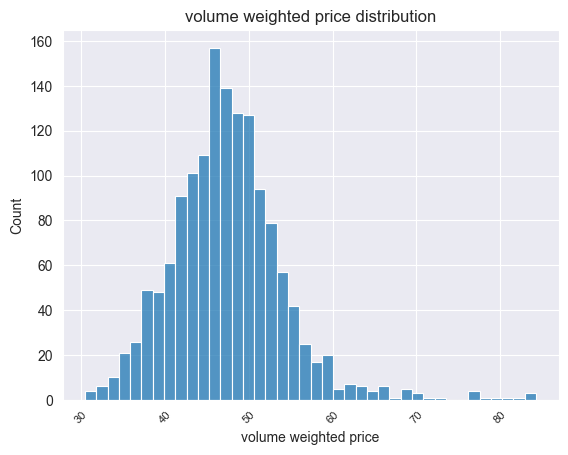

In [1144]:
plt.xticks(rotation=45,fontsize=8)
plt.Axes.minorticks_on
sns.histplot(data = EnergyCost_df, x="volume weighted price").set(title='volume weighted price distribution')
# plt.savefig("RESSqft.svg", format='svg')

Nothing in the volume weighted price visualization appears unreasonable, at this time there is no reason to suspect corrupted energy cost data.

# Merge Data

In [1145]:
LondonEnergy_df.head()

,Date,avgKWH
0,2011-11-23,6.952692
1,2011-11-24,8.536480
2,2011-11-25,9.499781
3,2011-11-26,10.267707
4,2011-11-27,10.850805


In [1146]:
LondonWeather_df.head()

,Date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-01-01,8.0,0.0,13.0,4.0,5.9,4.6,0.6,102500.0,0.0
1,2011-01-02,8.0,0.1,15.0,2.9,3.0,1.9,0.0,102830.0,0.0
2,2011-01-03,7.0,0.1,15.0,6.0,1.3,-0.3,0.0,102460.0,0.0
3,2011-01-04,7.0,0.0,13.0,7.1,2.9,-0.3,0.0,101360.0,0.0
4,2011-01-05,6.0,2.3,31.0,5.1,4.2,1.3,1.0,100040.0,0.0


In [1147]:
EnergyCost_df.head()

,Date,volume weighted price
0,2011-01-01,47.744
1,2011-01-02,55.180
2,2011-01-03,49.660
3,2011-01-04,53.390
4,2011-01-05,48.530


In [1148]:
CleanedData_df = pd.merge(LondonEnergy_df, EnergyCost_df, on="Date")
CleanedData_df = pd.merge(CleanedData_df, LondonWeather_df, on="Date")
print(CleanedData_df.columns)
CleanedData_df

Index(['Date', 'avgKWH', 'volume weighted price', 'cloud_cover', 'sunshine',
       'global_radiation', 'max_temp', 'mean_temp', 'min_temp',
       'precipitation', 'pressure', 'snow_depth'],
      dtype='object')


,Date,avgKWH,volume weighted price,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-11-23,6.952692,49.85,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,44.97,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,42.66,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,41.20,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,42.83,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,10.092758,42.81,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,0.0
825,2014-02-25,10.042841,41.60,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,0.0
826,2014-02-26,9.992153,47.71,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,0.0
827,2014-02-27,10.045084,45.77,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,0.0


# Engineer base model features.

In [1149]:
# Elapsed days
MIN_DATE = CleanedData_df['Date'].min()
CleanedData_df['days_elapsed'] = CleanedData_df.apply(lambda x: (x["Date"] - MIN_DATE).days, axis=1)
# Yesterdays power usage
CleanedData_df["(-1)avgKWH"] = CleanedData_df['avgKWH'].shift(periods = 1)
# Average power of the last three days
CleanedData_df['SMA3_avgKWH'] = CleanedData_df['avgKWH'].rolling(3).mean()
CleanedData_df

,Date,avgKWH,volume weighted price,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,days_elapsed,(-1)avgKWH,SMA3_avgKWH
0,2011-11-23,6.952692,49.85,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0,0,NaN,NaN
1,2011-11-24,8.536480,44.97,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0,1,6.952692,NaN
2,2011-11-25,9.499781,42.66,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0,2,8.536480,8.329651
3,2011-11-26,10.267707,41.20,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0,3,9.499781,9.434656
4,2011-11-27,10.850805,42.83,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0,4,10.267707,10.206098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,10.092758,42.81,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,0.0,824,11.078963,10.509701
825,2014-02-25,10.042841,41.60,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,0.0,825,10.092758,10.404854
826,2014-02-26,9.992153,47.71,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,0.0,826,10.042841,10.042584
827,2014-02-27,10.045084,45.77,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,0.0,827,9.992153,10.026693


# Engineer cyclical time series features.

Add cyclical time series variable month, week of year, and time of year

In [1150]:
date_time = pd.to_datetime(CleanedData_df['Date'], format='%Y-%m-%d')
timestamp_s = date_time.map(pd.Timestamp.timestamp) #Dates in seconds

# Day of week
weekday = CleanedData_df["Date"].apply(lambda dt: dt.weekday())
CleanedData_df['weekday sin'] = np.sin(weekday*(2*np.pi/7))
CleanedData_df['weekday cos'] = np.cos(weekday*(2*np.pi/7))
# Month of the year
month = CleanedData_df["Date"].apply(lambda dt: dt.month)
CleanedData_df['month sin'] = np.sin(month*(2*np.pi/12))
CleanedData_df['month cos'] = np.cos(month*(2*np.pi/12))
#From tensorflow time_series #Feature-engineering example
# Time of year
day = 24*60*60
year = (365.2425)*day
CleanedData_df['Time of Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
CleanedData_df['Time of Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
# Year
CleanedData_df['year'] = CleanedData_df["Date"].apply(lambda dt: dt.year)
CleanedData_df
# Season
# 0=spring,1=summer,2=fall,3=winter
MonthToSeasonMapping = {1: 3, 2: 3, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 3}
season = CleanedData_df['Date'].dt.month.map(MonthToSeasonMapping)
CleanedData_df['season sin'] = np.sin(season * (2 * np.pi / 4))
CleanedData_df['season cos'] = np.cos(season * (2 * np.pi / 4))

# Engineer delayed energy cost for continuity
We won't have access to the energy cost data beforehand therefore we have to shift the cost data by one so that we are always using yesterday's data

In [1151]:
# Yesterday's power cost
CleanedData_df["(-1)volume weighted price"] = CleanedData_df['volume weighted price'].shift(periods = 1)
CleanedData_df.pop('volume weighted price')
CleanedData_df

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday sin,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price
0,2011-11-23,6.952692,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,...,0.974928,-0.222521,-0.500000,0.866025,-0.624187,0.781275,2011,1.224647e-16,-1.000000e+00,NaN
1,2011-11-24,8.536480,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,...,0.433884,-0.900969,-0.500000,0.866025,-0.610655,0.791896,2011,1.224647e-16,-1.000000e+00,49.85
2,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,...,-0.433884,-0.900969,-0.500000,0.866025,-0.596943,0.802284,2011,1.224647e-16,-1.000000e+00,44.97
3,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.974928,-0.222521,-0.500000,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.000000e+00,42.66
4,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,-0.781831,0.623490,-0.500000,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.000000e+00,41.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,2014-02-24,10.092758,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,...,0.000000,1.000000,0.866025,0.500000,0.804377,0.594119,2014,-1.000000e+00,-1.836970e-16,38.19
825,2014-02-25,10.042841,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,...,0.781831,0.623490,0.866025,0.500000,0.814478,0.580194,2014,-1.000000e+00,-1.836970e-16,42.81
826,2014-02-26,9.992153,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,...,0.974928,-0.222521,0.866025,0.500000,0.824338,0.566097,2014,-1.000000e+00,-1.836970e-16,41.60
827,2014-02-27,10.045084,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,...,0.433884,-0.900969,0.866025,0.500000,0.833954,0.551833,2014,-1.000000e+00,-1.836970e-16,47.71


By implementing the time offset variables we have created three records with NA values, lets drop those.

In [1152]:
CleanedData_df = CleanedData_df.dropna()
CleanedData_df = CleanedData_df.reset_index(drop=True)
CleanedData_df

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday sin,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price
0,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,...,-0.433884,-0.900969,-0.500000,0.866025,-0.596943,0.802284,2011,1.224647e-16,-1.000000e+00,44.97
1,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.974928,-0.222521,-0.500000,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.000000e+00,42.66
2,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,-0.781831,0.623490,-0.500000,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.000000e+00,41.20
3,2011-11-28,9.103382,5.0,0.0,15.0,13.9,6.7,0.2,0.0,102270.0,...,0.000000,1.000000,-0.500000,0.866025,-0.554762,0.832009,2011,1.224647e-16,-1.000000e+00,42.83
4,2011-11-29,9.274873,6.0,0.0,15.0,12.8,8.6,3.3,0.4,100960.0,...,0.781831,0.623490,-0.500000,0.866025,-0.540368,0.841429,2011,1.224647e-16,-1.000000e+00,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,2014-02-24,10.092758,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,...,0.000000,1.000000,0.866025,0.500000,0.804377,0.594119,2014,-1.000000e+00,-1.836970e-16,38.19
823,2014-02-25,10.042841,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,...,0.781831,0.623490,0.866025,0.500000,0.814478,0.580194,2014,-1.000000e+00,-1.836970e-16,42.81
824,2014-02-26,9.992153,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,...,0.974928,-0.222521,0.866025,0.500000,0.824338,0.566097,2014,-1.000000e+00,-1.836970e-16,41.60
825,2014-02-27,10.045084,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,...,0.433884,-0.900969,0.866025,0.500000,0.833954,0.551833,2014,-1.000000e+00,-1.836970e-16,47.71


Fix days elapsed

In [1153]:
# Elapsed days
MIN_DATE = CleanedData_df['Date'].min()
CleanedData_df['days_elapsed'] = CleanedData_df.apply(lambda x: (x["Date"] - MIN_DATE).days, axis=1)

(array([15340., 15431., 15522., 15614., 15706., 15796., 15887., 15979.,
        16071., 16161.]),
 [Text(15340.0, 0, '2012-01'),
  Text(15431.0, 0, '2012-04'),
  Text(15522.0, 0, '2012-07'),
  Text(15614.0, 0, '2012-10'),
  Text(15706.0, 0, '2013-01'),
  Text(15796.0, 0, '2013-04'),
  Text(15887.0, 0, '2013-07'),
  Text(15979.0, 0, '2013-10'),
  Text(16071.0, 0, '2014-01'),
  Text(16161.0, 0, '2014-04')])

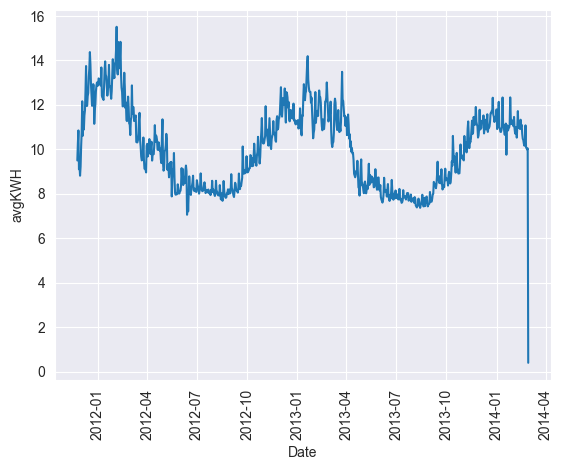

In [1154]:
sns.lineplot(y = CleanedData_df['avgKWH'],x=CleanedData_df['Date'])
plt.xticks(rotation=90)

In [1155]:
# CleanedData_df = CleanedData_df.sort_values("Date")
# CleanedData_df = CleanedData_df.reset_index(drop=True)
# CleanedData_df

There are no nulls and all days are present

In [1156]:
CleanedData_df.describe()

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday sin,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price
count,827,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,...,827.000000,827.000000,8.270000e+02,8.270000e+02,827.000000,827.000000,827.000000,8.270000e+02,8.270000e+02,827.000000
mean,2013-01-11 00:00:00,10.028726,4.713422,3.858404,105.229746,14.525393,10.780895,6.987545,1.915719,101402.297461,...,-0.000525,-0.001089,4.073341e-02,9.166976e-02,0.018767,0.102044,2012.539299,-1.051995e-01,-4.836759e-03,48.704256
min,2011-11-25 00:00:00,0.394141,0.000000,0.000000,12.000000,-0.200000,-2.600000,-7.600000,0.000000,97900.000000,...,-0.974928,-0.900969,-1.000000e+00,-1.000000e+00,-0.999998,-1.000000,2011.000000,-1.000000e+00,-1.000000e+00,31.900000
25%,2012-06-18 12:00:00,8.361517,3.000000,0.300000,35.000000,10.000000,6.700000,2.950000,0.000000,100740.000000,...,-0.781831,-0.900969,-5.000000e-01,-5.000000e-01,-0.629062,-0.627499,2012.000000,-1.000000e+00,-1.836970e-16,43.900000
50%,2013-01-11 00:00:00,10.052385,5.000000,2.900000,78.000000,13.300000,9.900000,6.700000,0.200000,101440.000000,...,0.000000,-0.222521,1.224647e-16,6.123234e-17,0.035237,0.203002,2013.000000,0.000000e+00,-1.836970e-16,47.710000
75%,2013-08-05 12:00:00,11.320382,7.000000,6.300000,163.500000,19.150000,15.200000,11.300000,2.200000,102165.000000,...,0.781831,0.623490,6.830127e-01,8.660254e-01,0.679793,0.828990,2013.000000,1.224647e-16,6.123234e-17,51.980000
max,2014-02-28 00:00:00,15.514456,8.000000,14.500000,333.000000,34.100000,25.400000,20.700000,29.800000,104120.000000,...,0.974928,1.000000,1.000000e+00,1.000000e+00,0.999990,0.999995,2014.000000,1.000000e+00,1.000000e+00,83.110000
std,NaN,1.780779,2.350385,3.807653,84.524624,6.596694,5.730702,5.272426,3.764984,1117.869837,...,0.707268,0.707801,6.898853e-01,7.177703e-01,0.683738,0.723142,0.693687,7.346885e-01,6.710736e-01,6.975088


In [1157]:
CleanedData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       827 non-null    datetime64[ns]
 1   avgKWH                     827 non-null    float64       
 2   cloud_cover                827 non-null    float64       
 3   sunshine                   827 non-null    float64       
 4   global_radiation           827 non-null    float64       
 5   max_temp                   827 non-null    float64       
 6   mean_temp                  827 non-null    float64       
 7   min_temp                   827 non-null    float64       
 8   precipitation              827 non-null    float64       
 9   pressure                   827 non-null    float64       
 10  snow_depth                 827 non-null    float64       
 11  days_elapsed               827 non-null    int64         
 12  (-1)avgK

# Save Final Data
Save the final cleaned dataset as a feather file to the clean data folder for use with other notebooks

In [1158]:
CleanedData_df.to_feather("../data/clean/CleanedData.feather")

# Ensure Save was sucessful

In [1159]:
Load_df = pd.read_feather("../data/clean/CleanedData.feather")
Load_df

,Date,avgKWH,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,...,weekday sin,weekday cos,month sin,month cos,Time of Year sin,Time of Year cos,year,season sin,season cos,(-1)volume weighted price
0,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,...,-0.433884,-0.900969,-0.500000,0.866025,-0.596943,0.802284,2011,1.224647e-16,-1.000000e+00,44.97
1,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,...,-0.974928,-0.222521,-0.500000,0.866025,-0.583054,0.812434,2011,1.224647e-16,-1.000000e+00,42.66
2,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,...,-0.781831,0.623490,-0.500000,0.866025,-0.568992,0.822343,2011,1.224647e-16,-1.000000e+00,41.20
3,2011-11-28,9.103382,5.0,0.0,15.0,13.9,6.7,0.2,0.0,102270.0,...,0.000000,1.000000,-0.500000,0.866025,-0.554762,0.832009,2011,1.224647e-16,-1.000000e+00,42.83
4,2011-11-29,9.274873,6.0,0.0,15.0,12.8,8.6,3.3,0.4,100960.0,...,0.781831,0.623490,-0.500000,0.866025,-0.540368,0.841429,2011,1.224647e-16,-1.000000e+00,46.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,2014-02-24,10.092758,4.0,4.4,82.0,10.7,10.9,6.8,3.2,100500.0,...,0.000000,1.000000,0.866025,0.500000,0.804377,0.594119,2014,-1.000000e+00,-1.836970e-16,38.19
823,2014-02-25,10.042841,5.0,2.0,60.0,11.8,9.4,8.1,2.6,100050.0,...,0.781831,0.623490,0.866025,0.500000,0.814478,0.580194,2014,-1.000000e+00,-1.836970e-16,42.81
824,2014-02-26,9.992153,1.0,7.7,111.0,12.0,7.4,2.9,2.8,101270.0,...,0.974928,-0.222521,0.866025,0.500000,0.824338,0.566097,2014,-1.000000e+00,-1.836970e-16,41.60
825,2014-02-27,10.045084,4.0,4.9,90.0,8.4,8.9,5.7,4.8,100700.0,...,0.433884,-0.900969,0.866025,0.500000,0.833954,0.551833,2014,-1.000000e+00,-1.836970e-16,47.71
